In [1]:
# Instalação das bibliotecas necessárias (executar apenas uma vez)
!pip install tensorflow scikit-learn matplotlib pillow numpy


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Importação das bibliotecas principais
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array


In [3]:
# Definições iniciais de parâmetros
img_size = (496, 248)      # Tamanho para redimensionar as imagens
batch_size = 8             # Tamanho do batch para treinamento
data_dir = "Data"          # Pasta com as imagens
EPOCHS_NUMS = 50           # Número de épocas de treinamento

# Listas para armazenar caminhos das imagens e rótulos
image_paths = []
labels = []

# Descobre as classes a partir das pastas e cria um dicionário de índices
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Percorre todas as imagens, armazena caminhos e rótulos
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_to_idx[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

# Divide os dados em treino, validação e teste de forma estratificada
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, stratify=y_temp, random_state=42
)

# Função para carregar e normalizar uma imagem (usada no pipeline do TensorFlow)
def preprocess_image(path, label):
    img = load_img(path.numpy().decode(), color_mode='grayscale', target_size=img_size)
    img = img_to_array(img) / 255.0
    return img, label

# Wrapper para usar a função acima no tf.data
def tf_preprocess(path, label):
    img, label = tf.py_function(preprocess_image, [path, label], [tf.float32, tf.int64])
    img.set_shape((img_size[0], img_size[1], 1))
    label.set_shape(())
    return img, label

# Função para criar datasets do TensorFlow
def make_dataset(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=42)
    ds = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Criação dos datasets de treino, validação e teste
train_ds = make_dataset(X_train, y_train)
val_ds = make_dataset(X_val, y_val, shuffle=False)
test_ds = make_dataset(X_test, y_test, shuffle=False)

print("Classes:", class_names)
print("Treino:", len(X_train), "Validação:", len(X_val), "Teste:", len(X_test))

2025-06-24 21:54:56.577743: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-24 21:54:56.577770: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-24 21:54:56.577777: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-24 21:54:56.577794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-24 21:54:56.577808: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
Treino: 8399 Validação: 1801 Teste: 1800


In [4]:
# Otimização do pipeline de dados
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
num_classes = len(class_names)

In [5]:
# Definição do modelo funcional com data augmentation no pipeline
from tensorflow.keras import layers, models

# Camadas de data augmentation aplicadas apenas durante o treino
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Arquitetura da rede neural convolucional
inputs = tf.keras.Input(shape=(img_size[0], img_size[1], 1))
x = data_augmentation(inputs)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compilação do modelo com otimizador Adam
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 496, 248, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 496, 248, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 496, 248, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 248, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 248, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 248, 124, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 124, 62, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 124, 62, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 62, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 62, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,583,364 (120.48 MB)

 Trainable params: 31,583,364 (120.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Treinamento do modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_NUMS,
    verbose=1,
)


Epoch 1/50


2025-06-24 21:54:57.566412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 272s 247ms/step - accuracy: 0.3243 - loss: 1.5001 - val_accuracy: 0.5097 - val_loss: 1.0399
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 248s 236ms/step - accuracy: 0.4607 - loss: 1.1484 - val_accuracy: 0.5625 - val_loss: 0.9477
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 215s 205ms/step - accuracy: 0.5119 - loss: 1.0523 - val_accuracy: 0.5902 - val_loss: 0.8618
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 220s 210ms/step - accuracy: 0.5390 - loss: 0.9962 - val_accuracy: 0.5214 - val_loss: 1.0412
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 216s 206ms/step - accuracy: 0.5659 - loss: 0.9797 - val_accuracy: 0.5936 - val_loss: 0.8299
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 219s 208ms/step - accuracy: 0.5732 - loss: 0.9586 - val_accuracy: 0.6491 - val_loss: 0.7750
Epoch 7/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 223s 212ms/step - accuracy: 0.5905 - loss: 0.9197 - val_accuracy: 0.5902 - val_loss: 0.9136
Epoch 8/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 222s 211ms/step - accuracy: 0.5

In [ ]:
# Avaliação do modelo no conjunto de teste
test_loss, test_acc = model.evaluate(test_ds)
print(f"Acurácia no teste: {test_acc:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6290 - loss: 0.8137
Acurácia no teste: 0.6317


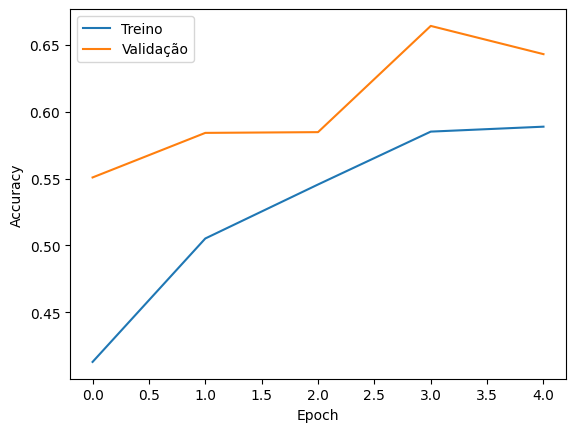

In [ ]:
# Plot das curvas de acurácia de treino e validação
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Função para prever e mostrar uma imagem
from matplotlib.pyplot import imshow

def predict(path):
    img = load_img(path, color_mode='grayscale', target_size=img_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    res = model.predict_on_batch(img_array)
    classification = np.where(res == np.amax(res))[1][0]

    imshow(img)
    print(str(round(res[0][classification] * 100, 2)) + '% Confidence This Is ' + class_names[classification])

    plt.imshow(img_array.squeeze(), cmap='gray')
    plt.title(f"Classe prevista: {class_names[classification]}")
    plt.axis('off')
    plt.show()

Predizendo imagem aleatória de Mild Dementia: OAS1_0053_MR1_mpr-3_107.jpg
80.86% Confidence This Is Mild Dementia


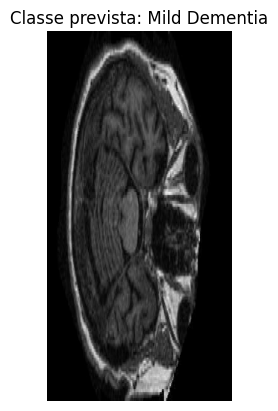

In [ ]:
# Sorteia uma pasta de classe e uma imagem aleatória para testar a predição
import random

random_folder = random.choice([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])
folder_path = os.path.join(data_dir, random_folder)

file = random.choice([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f"Predizendo imagem aleatória de {random_folder}: {file}")
predict(os.path.join(folder_path, file))